<a href="https://colab.research.google.com/github/syedjaleel850/Clone-website/blob/main/Swin_Transformer_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split

def load_images_and_masks(image_folder, mask_folders, target_size=(128, 128)):
    images, masks = [], []

    # Load images
    for img_name in sorted(os.listdir(image_folder)):
        img = load_img(os.path.join(image_folder, img_name), target_size=target_size)
        images.append(img_to_array(img))

    # Load masks for each lesion
    num_images = len(images)  # Get the number of images
    num_lesions = len(mask_folders)  # Get the number of lesion types
    masks = np.zeros((num_images, target_size[0], target_size[1], num_lesions)) # Initialize masks array

    for lesion_index, lesion_folder in enumerate(mask_folders):
        for image_index, mask_name in enumerate(sorted(os.listdir(lesion_folder))):
            mask = load_img(os.path.join(lesion_folder, mask_name), color_mode="grayscale", target_size=target_size)
            masks[image_index, :, :, lesion_index] = img_to_array(mask)[:, :, 0]  # Assign mask to correct position

    images = np.array(images) / 255.0  # Normalize images
    masks = masks / 255.0  # Normalize masks
    return images, masks

# Define paths
image_folder = "/content/drive/MyDrive/IDRID/A.%20Segmentation/A. Segmentation/1. Original Images/a. Training Set"
mask_folders = [
    "/content/drive/MyDrive/IDRID/A.%20Segmentation/A. Segmentation/2. All Segmentation Groundtruths/a. Training Set/1. Microaneurysms",
    "/content/drive/MyDrive/IDRID/A.%20Segmentation/A. Segmentation/2. All Segmentation Groundtruths/a. Training Set/2. Haemorrhages",
    "/content/drive/MyDrive/IDRID/A.%20Segmentation/A. Segmentation/2. All Segmentation Groundtruths/a. Training Set/3. Hard Exudates",
    "/content/drive/MyDrive/IDRID/A.%20Segmentation/A. Segmentation/2. All Segmentation Groundtruths/a. Training Set/4. Soft Exudates",
    "/content/drive/MyDrive/IDRID/A.%20Segmentation/A. Segmentation/2. All Segmentation Groundtruths/a. Training Set/5. Optic Disc",
]

# Load data with target_size matching the model input shape
images, masks = load_images_and_masks(image_folder, mask_folders, target_size=(128, 128))  # Smaller target size

# Split data
X_train, X_test, y_train, y_test = train_test_split(images, masks, test_size=0.3, random_state=42)

# Create TensorFlow datasets
batch_size = 8  # Adjust based on GPU memory
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(len(X_train)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_dataset = test_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [2]:
# Print the shapes of the datasets
print(f"Images shape: {images.shape}")
print(f"Masks shape: {masks.shape}")

# Print the shapes of training and testing sets
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

Images shape: (54, 128, 128, 3)
Masks shape: (54, 128, 128, 5)
X_train shape: (37, 128, 128, 3)
X_test shape: (17, 128, 128, 3)
y_train shape: (37, 128, 128, 5)
y_test shape: (17, 128, 128, 5)


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
for i, folder in enumerate(mask_folders):
    print(f"Lesion {i+1} folder contains {len(os.listdir(folder))} masks")

Lesion 1 folder contains 54 masks
Lesion 2 folder contains 53 masks
Lesion 3 folder contains 54 masks
Lesion 4 folder contains 26 masks
Lesion 5 folder contains 54 masks


In [8]:
print(f"Number of images: {images.shape[0]}")
print(f"Number of masks: {masks.shape[0]}")

Number of images: 54
Number of masks: 54


In [21]:
def patch_partition(images, patch_size=16):
    """
    Divides input images into non-overlapping patches of size (patch_size x patch_size).

    Parameters:
        images (tf.Tensor or np.ndarray): Input images of shape (batch_size, H, W, C) or (H, W, C).
        patch_size (int): Size of each patch (default: 4).

    Returns:
        patches (tf.Tensor): Tensor of shape (batch_size, num_patches, patch_size * patch_size * C).
    """
    # Convert images to TensorFlow tensor if it's a NumPy array
    if isinstance(images, np.ndarray):
        images = tf.convert_to_tensor(images, dtype=tf.float32)

    # Handle single image input by adding a batch dimension
    if len(images.shape) == 3:  # (H, W, C)
        images = tf.expand_dims(images, axis=0)  # Add batch dimension

    # Ensure input dimensions are valid
    assert len(images.shape) == 4, "Input must have shape (batch_size, H, W, C)"
    batch_size, H, W, C = images.shape

    # Ensure image dimensions are divisible by patch_size
    assert H % patch_size == 0 and W % patch_size == 0, "Image dimensions must be divisible by patch size"

    # Extract patches using TensorFlow's extract_patches
    patches = tf.image.extract_patches(
        images=images,
        sizes=[1, patch_size, patch_size, 1],
        strides=[1, patch_size, patch_size, 1],
        rates=[1, 1, 1, 1],
        padding="VALID",
    )

    # Reshape patches into flattened vectors
    patch_height = H // patch_size
    patch_width = W // patch_size
    patches = tf.reshape(patches, (batch_size, patch_height * patch_width, patch_size * patch_size * C))
    return patches

# Call patch_partition on the images
image_patches = patch_partition(images, patch_size=16)
print("Shape of image patches:", image_patches.shape)
# Print the number of patches for the first image
num_patches_first_image = image_patches.shape[1]  # shape: (batch_size, num_patches, patch_size * patch_size * C)
print(f"Number of patches formed for the first image: {num_patches_first_image}")


In [ ]:
import numpy as np
import tensorflow as tf

# Define a sample image batch (e.g., batch of 2 images of size 128x128x3 from your dataset)
# You can load your dataset here instead of using random images
sample_images = np.random.randint(0, 256, (2, 128, 128, 3)).astype(np.float32)

# Patch size
patch_size = 16

# Call the patch_partition function
patches = patch_partition(images, patch_size=patch_size)

# Print the input and output shapes for verification
print("Input shape:", images.shape)
print("Output shape:", patches.shape)

# Verify expected output shape
expected_num_patches = (128 // patch_size) * (128 // patch_size)  # Number of patches per image
expected_patch_vector_size = patch_size * patch_size * 3          # Flattened patch size

print("Expected output shape:", (2, expected_num_patches, expected_patch_vector_size))

# Optionally, inspect the patches
print("Sample patch data:", patches[0, 0])  # First patch of the first image

In [22]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Add
from tensorflow.keras.initializers import TruncatedNormal

class PatchEmbedding(tf.keras.layers.Layer):
    def __init__(self, embed_dim=96, **kwargs):
        """
        Initializes the Patch Embedding layer.
        Args:
            embed_dim (int): Dimension of the embedding space.
        """
        super(PatchEmbedding, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.projection = Dense(embed_dim, kernel_initializer=TruncatedNormal(stddev=0.02))

    def build(self, input_shape):
        # Positional embeddings for all patches
        num_patches = input_shape[-2]  # The number of patches (e.g., 4096)
        self.positional_embedding = self.add_weight(
            shape=(1, num_patches, self.embed_dim),
            initializer=TruncatedNormal(stddev=0.02),
            trainable=True,
            name="positional_embedding"
        )
        super(PatchEmbedding, self).build(input_shape)

    def call(self, x):
        # Flatten last dimensions to ensure compatibility with Dense
        x = tf.reshape(x, (x.shape[0], -1, x.shape[-1]))  # Flatten spatial dimensions
        # Project patches into embedding space
        x = self.projection(x)
        # Add positional embeddings
        x = x + self.positional_embedding
        return x

# Instantiate the layer
patch_embedding_layer = PatchEmbedding(embed_dim=96)

# Correct input patch shapes for testing
image_patches = tf.random.normal((54, 256, 1280))  # Example: Adjusted input shape
mask_patches = tf.random.normal((54, 256, 1280))   # Example: Adjusted input shape

# Apply Patch Embedding
image_embeddings = patch_embedding_layer(image_patches)  # Shape: (54, 256, 96)
mask_embeddings = patch_embedding_layer(mask_patches)    # Shape: (54, 256, 96)

# Print shapes to validate
print(f"Image embeddings shape: {image_embeddings.shape}")
print(f"Mask embeddings shape: {mask_embeddings.shape}")

Image embeddings shape: (54, 256, 96)
Mask embeddings shape: (54, 256, 96)


In [11]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Add
from tensorflow.keras.initializers import TruncatedNormal

class PatchEmbedding(tf.keras.layers.Layer):
    def __init__(self, embed_dim=96, **kwargs):
        """
        Initializes the Patch Embedding layer.
        Args:
            embed_dim (int): Dimension of the embedding space.
        """
        super(PatchEmbedding, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.projection = Dense(embed_dim, kernel_initializer=TruncatedNormal(stddev=0.02))

    def build(self, input_shape):
        # Positional embeddings for all patches
        num_patches = input_shape[-2]  # The number of patches (e.g., 4096)
        self.positional_embedding = self.add_weight(
            shape=(1, num_patches, self.embed_dim),
            initializer=TruncatedNormal(stddev=0.02),
            trainable=True,
            name="positional_embedding"
        )
        super(PatchEmbedding, self).build(input_shape)

    def call(self, x):
        # Project patches into embedding space
        x = self.projection(x)
        # Add positional embeddings
        x = x + self.positional_embedding
        return x

# Instantiate the layer
patch_embedding_layer = PatchEmbedding(embed_dim=96)

# # Correct input patch shapes for testing
# image_patches = tf.random.normal((54, 4096, 48))  # Input: 54 samples, 4096 patches, 48 channels
# mask_patches = tf.random.normal((54, 4096, 48))

# Apply Patch Embedding
image_embeddings = patch_embedding_layer(image_patches)  # Shape: (54, 4096, 96)
mask_embeddings = patch_embedding_layer(mask_patches)    # Shape: (54, 4096, 96)

# Print shapes to validate
print(f"Image embeddings shape: {image_embeddings.shape}")
print(f"Mask embeddings shape: {mask_embeddings.shape}")

Image embeddings shape: (54, 256, 96)
Mask embeddings shape: (54, 256, 96)


In [17]:
# import tensorflow as tf
# from tensorflow.keras.layers import Dense, LayerNormalization, Add
# from tensorflow.keras.initializers import TruncatedNormal

# class SwinTransformerBlock(tf.keras.layers.Layer):
#     def __init__(self, embed_dim, num_heads, window_size=4, **kwargs):
#         """
#         Swin Transformer Block with Window-based Multi-Head Self-Attention and MLP.
#         Args:
#             embed_dim (int): Embedding dimension.
#             num_heads (int): Number of attention heads.
#             window_size (int): Window size for self-attention.
#         """
#         super(SwinTransformerBlock, self).__init__(**kwargs)
#         self.embed_dim = embed_dim
#         self.num_heads = num_heads
#         self.window_size = window_size

#         # Multi-Head Self-Attention (W-MSA)
#         self.msa = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)

#         # MLP
#         self.mlp = tf.keras.Sequential([
#             Dense(embed_dim * 4, activation="gelu"),
#             Dense(embed_dim)
#         ])

#         # Normalization layers
#         self.layer_norm1 = LayerNormalization()
#         self.layer_norm2 = LayerNormalization()

#     def call(self, x):
#         # Window-based Multi-Head Self-Attention
#         attn_output = self.msa(x, x)
#         x = self.layer_norm1(x + attn_output)  # Residual connection and normalization

#         # Feed-forward MLP
#         mlp_output = self.mlp(x)
#         x = self.layer_norm2(x + mlp_output)  # Residual connection and normalization
#         return x


# class SwinEncoder(tf.keras.layers.Layer):
#     def __init__(self, embed_dim, num_heads, depths, window_size=4, **kwargs):
#         """
#         Swin Transformer Encoder with hierarchical downsampling.
#         Args:
#             embed_dim (int): Initial embedding dimension.
#             num_heads (list[int]): List of attention heads for each stage.
#             depths (list[int]): Number of Swin Transformer blocks per stage.
#             window_size (int): Window size for attention.
#         """
#         super(SwinEncoder, self).__init__(**kwargs)
#         self.stages = []
#         self.downsamplers = []  # Separate downsampling layers
#         for i in range(len(depths)):
#             # Create a stage of SwinTransformerBlocks
#             stage = [
#                 SwinTransformerBlock(embed_dim=embed_dim * (2 ** i),
#                                      num_heads=num_heads[i],
#                                      window_size=window_size)
#                 for _ in range(depths[i])
#             ]
#             self.stages.append(stage)

#             # Add downsampling layer except for the last stage
#             if i < len(depths) - 1:
#                 self.downsamplers.append(
#                     tf.keras.layers.Conv2D(embed_dim * (2 ** (i + 1)), kernel_size=3, strides=2, padding="same")
#                 )

#     def call(self, x):
#         features = []
#         for i, stage in enumerate(self.stages):
#             # Process all blocks in the current stage
#             for block in stage:
#                 x = block(x)

#             features.append(x)  # Save output of this stage

#             # Apply downsampling if it's not the last stage
#             if i < len(self.downsamplers):
#                 x = self.downsamplers[i](x)

#         return features

# class Bottleneck(tf.keras.layers.Layer):
#     def __init__(self, embed_dim, num_heads, num_blocks, window_size=4, **kwargs):
#         """
#         Bottleneck layer with multiple Swin Transformer blocks.
#         Args:
#             embed_dim (int): Embedding dimension for bottleneck.
#             num_heads (int): Number of attention heads.
#             num_blocks (int): Number of Swin Transformer blocks in the bottleneck.
#             window_size (int): Window size for attention.
#         """
#         super(Bottleneck, self).__init__(**kwargs)
#         self.blocks = [
#             SwinTransformerBlock(embed_dim=embed_dim, num_heads=num_heads, window_size=window_size)
#             for _ in range(num_blocks)
#         ]

#     def call(self, x):
#         for block in self.blocks:
#             x = block(x)  # Pass through each Swin Transformer block
#         return x
# class PatchExpanding(tf.keras.layers.Layer):
#     def __init__(self, embed_dim, scale=2, **kwargs):
#         """
#         Patch expanding (upsampling) layer.
#         Args:
#             embed_dim (int): Embedding dimension of input features.
#             scale (int): Upsampling scale (default: 2).
#         """
#         super(PatchExpanding, self).__init__(**kwargs)
#         self.scale = scale
#         # Calculate the correct output size based on scale
#         self.expand = Dense(embed_dim * (scale ** 2), activation=None)
#         self.reshape = tf.keras.layers.Reshape((-1, embed_dim))

#     def call(self, x, input_shape):
#         B, H, W, C = x.shape  # Adjust for unflattened input

#         # Expand and reshape
#         x = self.expand(x)  # Linear layer for upsampling
#         new_H = H * self.scale
#         new_W = W * self.scale

#         # Ensure the number of elements match
#         x = tf.reshape(x, (B, new_H, new_W, C // (self.scale ** 2)))
#         return x

# class SwinDecoder(tf.keras.layers.Layer):
#     def __init__(self, embed_dim, num_heads, depths, skip_dims, window_size=4, **kwargs):
#         """
#         Swin U-Net decoder with skip connections.
#         Args:
#             embed_dim (int): Initial embedding dimension.
#             num_heads (list[int]): Number of attention heads for each stage.
#             depths (list[int]): Number of Swin Transformer blocks per stage.
#             skip_dims (list[int]): Dimensions of features from encoder for skip connections.
#             window_size (int): Window size for attention.
#         """
#         super(SwinDecoder, self).__init__(**kwargs)
#         self.stages = []
#         self.patch_expanding_layers = []
#         for i in range(len(depths)):
#             # Patch Expanding (Upsampling)
#             self.patch_expanding_layers.append(PatchExpanding(embed_dim=skip_dims[-(i + 1)]))

#             # Swin Transformer blocks in decoder stage
#             stage = [
#                 SwinTransformerBlock(embed_dim=embed_dim // (2 ** i),
#                                      num_heads=num_heads[-(i + 1)],
#                                      window_size=window_size)
#                 for _ in range(depths[i])
#             ]
#             self.stages.append(stage)

#     def call(self, x, skip_features):
#         """
#         Args:
#             x (tf.Tensor): Input feature map from bottleneck.
#             skip_features (list[tf.Tensor]): List of feature maps from encoder for skip connections.
#         Returns:
#             tf.Tensor: Final output after decoding.
#         """
#         for i, stage in enumerate(self.stages):
#             # Upsample using PatchExpanding
#             x = self.patch_expanding_layers[i](x, input_shape=(x.shape[1], x.shape[2]))

#             # Concatenate skip connections
#             x = tf.concat([x, skip_features[-(i + 1)]], axis=-1)

#             # Process Swin Transformer blocks in the current stage
#             for block in stage:
#                 x = block(x)

#         return x

# # Instantiate the encoder with memory-efficient settings
# swin_encoder = SwinEncoder(embed_dim=96, num_heads=[3, 6, 12, 24], depths=[2, 2, 6, 2], window_size=4)

# # Define the Bottleneck Layer
# bottleneck = Bottleneck(embed_dim=768, num_heads=24, num_blocks=2, window_size=4)

# # Define Decoder
# decoder = SwinDecoder(embed_dim=768, num_heads=[3, 6, 12, 24], depths=[2, 2, 6, 2],
#                       skip_dims=[96, 192, 384, 768], window_size=4)


# # Prepare a smaller batch size and properly sized dummy data for testing
# image_embeddings = tf.random.normal((4, 64, 64, 96))  # Shape after patch embedding for a smaller batch

# # Apply the Swin Encoder
# features = swin_encoder(image_embeddings)  # Run Swin Encoder

# # Print the shape of features at each stage
# for i, feature in enumerate(features):
#     print(f"Feature shape at stage {i + 1}: {feature.shape}")

# # Pass through Bottleneck (deepest feature map from the encoder)
# bottleneck_features = bottleneck(features[-1])  # Use the last feature map
# print(f"Bottleneck output shape: {bottleneck_features.shape}")

# # Pass through Decoder (skip connections from encoder features)
# decoded_output = decoder(bottleneck_features, features[:-1])  # Exclude bottleneck from skip connections

# print(f"Decoder output shape: {decoded_output.shape}")

Feature shape at stage 1: (4, 64, 64, 96)
Feature shape at stage 2: (4, 32, 32, 192)
Feature shape at stage 3: (4, 16, 16, 384)
Feature shape at stage 4: (4, 8, 8, 768)
Bottleneck output shape: (4, 8, 8, 768)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:1383: UserWarning: Layer 'swin_decoder_3' looks like it has unbuilt state, but Keras is not able to trace the layer `call()` in order to build it automatically. Possible causes:
1. The `call()` method of your layer may be crashing. Try to `__call__()` the layer eagerly on some test input first to see if it works. E.g. `x = np.random.random((3, 4)); y = layer(x)`
2. If the `call()` method is correct, then you may need to implement the `def build(self, input_shape)` method on your layer. It should create all variables used by the layer (e.g. by calling `layer.build()` on all its children layers).
Exception encountered: ''Exception encountered when calling PatchExpanding.call().

Cannot reshape a tensor with 786432 elements to shape [4,16,16,192] (196608 elements) for '{{node patch_expanding_12_1/Reshape}} = Reshape[T=DT_FLOAT, Tshape=DT_INT32](patch_expanding_12_1/dense_250_1/Add, patch_expanding_12_1/Reshape/shape)' with 

InvalidArgumentError: Exception encountered when calling PatchExpanding.call().

[1m{{function_node __wrapped__Reshape_device_/job:localhost/replica:0/task:0/device:GPU:0}} Input to reshape is a tensor with 786432 values, but the requested shape has 196608 [Op:Reshape][0m

Arguments received by PatchExpanding.call():
  • x=tf.Tensor(shape=(4, 8, 8, 768), dtype=float32)
  • input_shape=('8', '8')

In [20]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, LayerNormalization, Add
from tensorflow.keras.initializers import TruncatedNormal

class SwinTransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, window_size=4, **kwargs):
        """
        Swin Transformer Block with Window-based Multi-Head Self-Attention and MLP.
        Args:
            embed_dim (int): Embedding dimension.
            num_heads (int): Number of attention heads.
            window_size (int): Window size for self-attention.
        """
        super(SwinTransformerBlock, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.window_size = window_size

        # Multi-Head Self-Attention (W-MSA)
        self.msa = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)

        # MLP
        self.mlp = tf.keras.Sequential([
            Dense(embed_dim * 4, activation="gelu"),
            Dense(embed_dim)
        ])

        # Normalization layers
        self.layer_norm1 = LayerNormalization()
        self.layer_norm2 = LayerNormalization()

    def call(self, x):
        # Window-based Multi-Head Self-Attention
        attn_output = self.msa(x, x)
        x = self.layer_norm1(x + attn_output)  # Residual connection and normalization

        # Feed-forward MLP
        mlp_output = self.mlp(x)
        x = self.layer_norm2(x + mlp_output)  # Residual connection and normalization
        return x


class SwinEncoder(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, depths, window_size=4, **kwargs):
        super(SwinEncoder, self).__init__(**kwargs)
        self.stages = []
        self.downsamplers = []  # Separate downsampling layers
        for i in range(len(depths)):
            stage = [
                SwinTransformerBlock(embed_dim=embed_dim * (2 ** i),
                                     num_heads=num_heads[i],
                                     window_size=window_size)
                for _ in range(depths[i])
            ]
            self.stages.append(stage)

            # Add downsampling layer except for the last stage
            if i < len(depths) - 1:
                self.downsamplers.append(
                    tf.keras.layers.Conv2D(embed_dim * (2 ** (i + 1)), kernel_size=3, strides=2, padding="same")
                )

    def call(self, x):
        features = []
        for i, stage in enumerate(self.stages):
            for block in stage:
                x = block(x)

            features.append(x)  # Save output of this stage

            if i < len(self.downsamplers):
                x = self.downsamplers[i](x)

        return features  # Return all feature maps for skip connections

class Bottleneck(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, num_blocks, window_size=4, **kwargs):
        """
        Bottleneck layer with multiple Swin Transformer blocks.
        Args:
            embed_dim (int): Embedding dimension for bottleneck.
            num_heads (int): Number of attention heads.
            num_blocks (int): Number of Swin Transformer blocks in the bottleneck.
            window_size (int): Window size for attention.
        """
        super(Bottleneck, self).__init__(**kwargs)
        self.blocks = [
            SwinTransformerBlock(embed_dim=embed_dim, num_heads=num_heads, window_size=window_size)
            for _ in range(num_blocks)
        ]

    def call(self, x):
        for block in self.blocks:
            x = block(x)  # Pass through each Swin Transformer block
        return x
class PatchExpanding(tf.keras.layers.Layer):
    def __init__(self, embed_dim, scale=2, **kwargs):
        """
        Patch expanding (upsampling) layer.
        Args:
            embed_dim (int): Embedding dimension of input features.
            scale (int): Upsampling scale (default: 2).
        """
        super(PatchExpanding, self).__init__(**kwargs)
        self.scale = scale
        # Calculate the correct output size based on scale
        self.expand = Dense(embed_dim * (scale ** 2), activation=None)
        self.reshape = tf.keras.layers.Reshape((-1, embed_dim))

    def call(self, x, input_shape):
        B, H, W, C = x.shape  # Adjust for unflattened input

        # Expand and reshape
        x = self.expand(x)  # Linear layer for upsampling

        # Correct new height and width after scaling
        new_H = H * self.scale
        new_W = W * self.scale

        # Ensure the number of elements match
        x = tf.reshape(x, (B, new_H, new_W, C // (self.scale ** 2)))  # Adjust dimensions properly

        return x

class SwinDecoder(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, depths, skip_dims, window_size=4, **kwargs):
        """
        Swin U-Net decoder with skip connections.
        Args:
            embed_dim (int): Initial embedding dimension.
            num_heads (list[int]): Number of attention heads for each stage.
            depths (list[int]): Number of Swin Transformer blocks per stage.
            skip_dims (list[int]): Dimensions of features from encoder for skip connections.
            window_size (int): Window size for attention.
        """
        super(SwinDecoder, self).__init__(**kwargs)
        self.stages = []
        self.patch_expanding_layers = []
        for i in range(len(depths)):
            # Patch Expanding (Upsampling)
            self.patch_expanding_layers.append(PatchExpanding(embed_dim=skip_dims[-(i + 1)]))

            # Swin Transformer blocks in decoder stage
            stage = [
                SwinTransformerBlock(embed_dim=embed_dim // (2 ** i),
                                     num_heads=num_heads[-(i + 1)],
                                     window_size=window_size)
                for _ in range(depths[i])
            ]
            self.stages.append(stage)

    def call(self, x, skip_features):
        """
        Args:
            x (tf.Tensor): Input feature map from bottleneck.
            skip_features (list[tf.Tensor]): List of feature maps from encoder for skip connections.
        Returns:
            tf.Tensor: Final output after decoding.
        """
        for i, stage in enumerate(self.stages):
            # Upsample using PatchExpanding
            x = self.patch_expanding_layers[i](x, input_shape=(x.shape[1], x.shape[2]))

            # Concatenate skip connections
            x = tf.concat([x, skip_features[-(i + 1)]], axis=-1)

            # Process Swin Transformer blocks in the current stage
            for block in stage:
                x = block(x)

        # After final decoder stage, apply a 1x1 convolution for segmentation
        x = tf.keras.layers.Conv2D(1, kernel_size=1, activation='sigmoid')(x)
        return x

# Instantiate the encoder
swin_encoder = SwinEncoder(embed_dim=96, num_heads=[3, 6, 12, 24], depths=[2, 2, 6, 2], window_size=4)

# Define the Bottleneck Layer
bottleneck = Bottleneck(embed_dim=768, num_heads=24, num_blocks=2, window_size=4)

# Define Decoder
decoder = SwinDecoder(embed_dim=768, num_heads=[3, 6, 12, 24], depths=[2, 2, 6, 2],
                      skip_dims=[96, 192, 384, 768], window_size=4)


# Prepare a smaller batch size and properly sized dummy data for testing
image_embeddings = tf.random.normal((4, 64, 64, 96))  # Shape after patch embedding for a smaller batch

# Apply the Swin Encoder
features = swin_encoder(image_embeddings)  # Run Swin Encoder

# Print the shape of features at each stage
for i, feature in enumerate(features):
    print(f"Feature shape at stage {i + 1}: {feature.shape}")

# Pass through Bottleneck (deepest feature map from the encoder)
bottleneck_features = bottleneck(features[-1])  # Use the last feature map
print(f"Bottleneck output shape: {bottleneck_features.shape}")

# Pass through Decoder (skip connections from encoder features)
decoded_output = decoder(bottleneck_features, features)  # Pass all encoder features as skip connections

print(f"Decoder output shape: {decoded_output.shape}")

Feature shape at stage 1: (4, 64, 64, 96)
Feature shape at stage 2: (4, 32, 32, 192)
Feature shape at stage 3: (4, 16, 16, 384)
Feature shape at stage 4: (4, 8, 8, 768)
Bottleneck output shape: (4, 8, 8, 768)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:1383: UserWarning: Layer 'swin_decoder_6' looks like it has unbuilt state, but Keras is not able to trace the layer `call()` in order to build it automatically. Possible causes:
1. The `call()` method of your layer may be crashing. Try to `__call__()` the layer eagerly on some test input first to see if it works. E.g. `x = np.random.random((3, 4)); y = layer(x)`
2. If the `call()` method is correct, then you may need to implement the `def build(self, input_shape)` method on your layer. It should create all variables used by the layer (e.g. by calling `layer.build()` on all its children layers).
Exception encountered: ''Exception encountered when calling PatchExpanding.call().

Cannot reshape a tensor with 786432 elements to shape [4,16,16,192] (196608 elements) for '{{node patch_expanding_24_1/Reshape}} = Reshape[T=DT_FLOAT, Tshape=DT_INT32](patch_expanding_24_1/dense_418_1/Add, patch_expanding_24_1/Reshape/shape)' with 

InvalidArgumentError: Exception encountered when calling PatchExpanding.call().

[1m{{function_node __wrapped__Reshape_device_/job:localhost/replica:0/task:0/device:GPU:0}} Input to reshape is a tensor with 786432 values, but the requested shape has 196608 [Op:Reshape][0m

Arguments received by PatchExpanding.call():
  • x=tf.Tensor(shape=(4, 8, 8, 768), dtype=float32)
  • input_shape=('8', '8')

In [ ]:
class PatchMerging(tf.keras.layers.Layer):
    def __init__(self, embed_dim):
        super(PatchMerging, self).__init__()
        self.reduction = tf.keras.layers.Dense(embed_dim * 2, activation=None)

    def call(self, x):
        batch_size, num_patches, embed_dim = x.shape
        h = w = int(tf.sqrt(tf.cast(num_patches, tf.float32)))

        # Reshape into (batch_size, h, w, channels)
        x = tf.reshape(x, (batch_size, h, w, embed_dim))

        # Combine neighboring patches
        x0 = x[:, ::2, ::2, :]
        x1 = x[:, 1::2, ::2, :]
        x2 = x[:, ::2, 1::2, :]
        x3 = x[:, 1::2, 1::2, :]
        x = tf.concat([x0, x1, x2, x3], axis=-1)  # (batch_size, h/2, w/2, 4*channels)

        # Linear transformation
        x = tf.reshape(x, (batch_size, -1, 4 * embed_dim))
        x = self.reduction(x)
        return x

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# --- 2. Swin U-Net with Attention Mechanism and Residual Blocks ---
from tensorflow.keras import layers, Model # Import layers and Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

class ResidualBlock(layers.Layer):
    def __init__(self, filters, **kwargs):
        super(ResidualBlock, self).__init__(**kwargs)
        self.conv1 = layers.Conv2D(filters, (3, 3), padding='same', activation='relu')
        self.conv2 = layers.Conv2D(filters, (3, 3), padding='same', activation='relu')
        # Add a 1x1 convolution to match the number of channels
        self.channel_adjust = layers.Conv2D(filters, (1, 1), padding='same') # Added a 1x1 conv
        self.add = layers.Add()

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.conv2(x)
        # Adjust the channels of the input to match the output of conv2
        inputs = self.channel_adjust(inputs) # Adjust input channels
        return self.add([x, inputs])

class SwinTransformerBlock(layers.Layer):
    def __init__(self, embed_dim=64, num_heads=4, window_size=7, shift_size=0, **kwargs):
        super(SwinTransformerBlock, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.window_size = window_size
        self.shift_size = shift_size

    def build(self, input_shape):
        self.norm1 = layers.LayerNormalization()
        self.attn = layers.MultiHeadAttention(num_heads=self.num_heads, key_dim=self.embed_dim // self.num_heads)
        self.norm2 = layers.LayerNormalization()
        self.mlp = tf.keras.Sequential([
            layers.Dense(self.embed_dim * 4, activation='gelu'),
            layers.Dense(self.embed_dim)
        ])

    def call(self, inputs):
        x = self.norm1(inputs)
        x = self.attn(x, x)
        x = x + inputs
        x = self.norm2(x)
        x = self.mlp(x)
        return x + inputs

def swin_unet(input_shape=(256, 256, 3)):
    inputs = layers.Input(input_shape)

    # Encoder: Downsampling path
    x1 = ResidualBlock(64)(inputs)
    x2 = layers.MaxPooling2D((2, 2))(x1)
    x2 = ResidualBlock(128)(x2)
    x3 = layers.MaxPooling2D((2, 2))(x2)
    x3 = ResidualBlock(256)(x3)
    x4 = layers.MaxPooling2D((2, 2))(x3)
    x4 = ResidualBlock(512)(x4)

    # Bottleneck: Swin Transformer Block
    x5 = SwinTransformerBlock(embed_dim=512)(x4)

    # Decoder: Upsampling path
    x6 = layers.UpSampling2D((2, 2))(x5)
    x6 = ResidualBlock(256)(x6)
    x6 = layers.Concatenate()([x6, x3])

    x7 = layers.UpSampling2D((2, 2))(x6)
    x7 = ResidualBlock(128)(x7)
    x7 = layers.Concatenate()([x7, x2])

    x8 = layers.UpSampling2D((2, 2))(x7)
    x8 = ResidualBlock(64)(x8)
    x8 = layers.Concatenate()([x8, x1])

    # Output layer with softmax activation for multi-class segmentation (5 classes)
    outputs = layers.Conv2D(5, (1, 1), activation='softmax')(x8)

    return Model(inputs, outputs)

# Instantiate the model
model = swin_unet(input_shape=(256, 256, 3))
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss=CategoricalCrossentropy(),
              metrics=['accuracy', tf.keras.metrics.MeanIoU(num_classes=5)])
model.summary()

# --- 3. Train the Model ---
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ModelCheckpoint("best_swin_unet_model_with_residuals_multi_lesions.keras", save_best_only=True)
]

model.fit(X_train, y_train,
          validation_data=(X_test, y_test),
          batch_size=4,
          epochs=10,
          callbacks=callbacks)

# Save the model
model.save("swin_unet_model_multi_lesions_final.h5")

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ residual_block            │ (None, 256, 256, 64)   │         38,976 │ input_layer[0][0]      │
│ (ResidualBlock)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 64)   │              0 │ residual_block[0][0]   │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ residual_block_1          │ (None, 128, 128, 128)  │        229,760 │ max_pooling2d[0][0]    │
│ (ResidualBlock)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 64, 64, 128)    │              0 │ residual_block_1[0][0] │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ residual_block_2          │ (None, 64, 64, 256)    │        918,272 │ max_pooling2d_1[0][0]  │
│ (ResidualBlock)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 32, 32, 256)    │              0 │ residual_block_2[0][0] │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ residual_block_3          │ (None, 32, 32, 512)    │      3,671,552 │ max_pooling2d_2[0][0]  │
│ (ResidualBlock)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ swin_transformer_block    │ (None, 32, 32, 512)    │      3,152,384 │ residual_block_3[0][0] │
│ (SwinTransformerBlock)    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d             │ (None, 64, 64, 512)    │              0 │ swin_transformer_bloc… │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ residual_block_4          │ (None, 64, 64, 256)    │      1,901,312 │ up_sampling2d[0][0]    │
│ (ResidualBlock)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 64, 64, 512)    │              0 │ residual_block_4[0][0… │
│                           │                        │                │ residual_block_2[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d_1           │ (None, 128, 128, 512)  │              0 │ concatenate[0][0]      │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ residual_block_5     

 Total params: 10,916,997 (41.65 MB)

 Trainable params: 10,916,997 (41.65 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 358s 35s/step - accuracy: 0.2935 - loss: 0.0209 - mean_io_u: 1.0000 - val_accuracy: 0.0260 - val_loss: 0.0162 - val_mean_io_u: 1.0000
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 381s 35s/step - accuracy: 0.0771 - loss: 0.0261 - mean_io_u: 1.0000 - val_accuracy: 0.0253 - val_loss: 0.1115 - val_mean_io_u: 1.0000
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 384s 34s/step - accuracy: 0.0671 - loss: 0.4234 - mean_io_u: 1.0000 - val_accuracy: 0.1717 - val_loss: 3.3693 - val_mean_io_u: 1.0000
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 405s 38s/step - accuracy: 0.2511 - loss: 19.5868 - mean_io_u: 1.0000 - val_accuracy: 0.0205 - val_loss: 448.8844 - val_mean_io_u: 1.0000
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 357s 35s/step - accuracy: 0.1629 - loss: 1090.2463 - mean_io_u: 1.0000 - val_accuracy: 0.0219 - val_loss: 4899.2456 - val_mean_io_u: 1.0000
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 431s 40s/step - accuracy: 0.2026 - loss: 28812.9004 - mean_io_u: 1.0000 - val_accuracy: 0.095

In [ ]:
# --- 4. Evaluate and Predict ---
predictions = model.predict(X_test)
predictions = np.argmax(predictions, axis=-1)  # Convert softmax output to class labels

# You can visualize or process the predicted labels as per the class

1/1 ━━━━━━━━━━━━━━━━━━━━ 41s 41s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 38s 38s/step


<ipython-input-7-f36fe8c18dcf>:26: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()


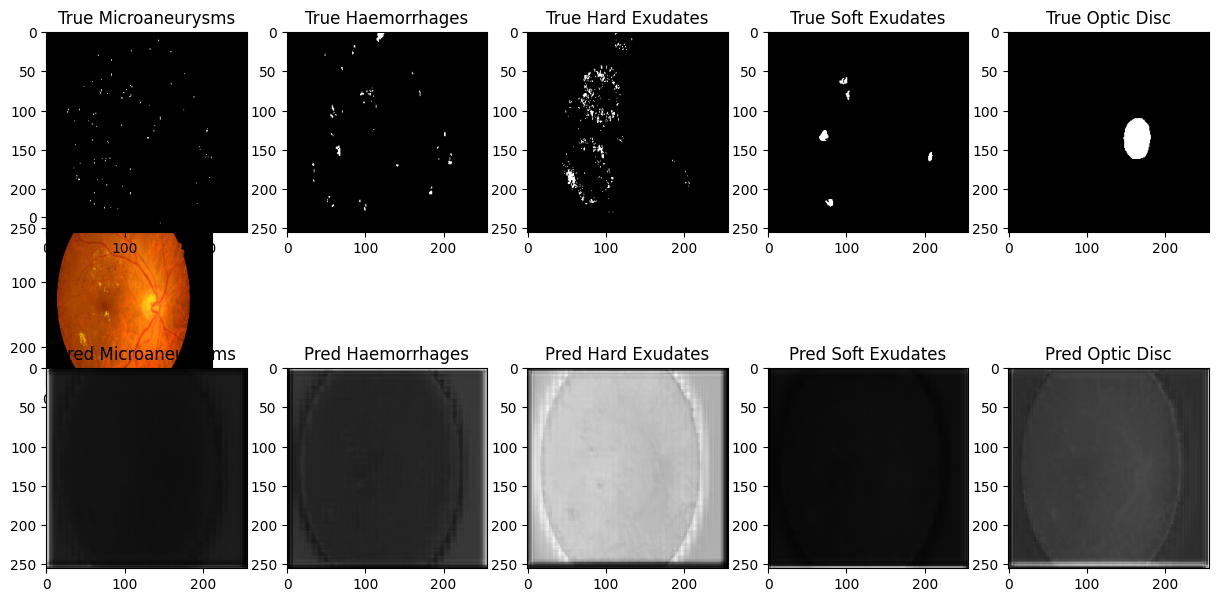

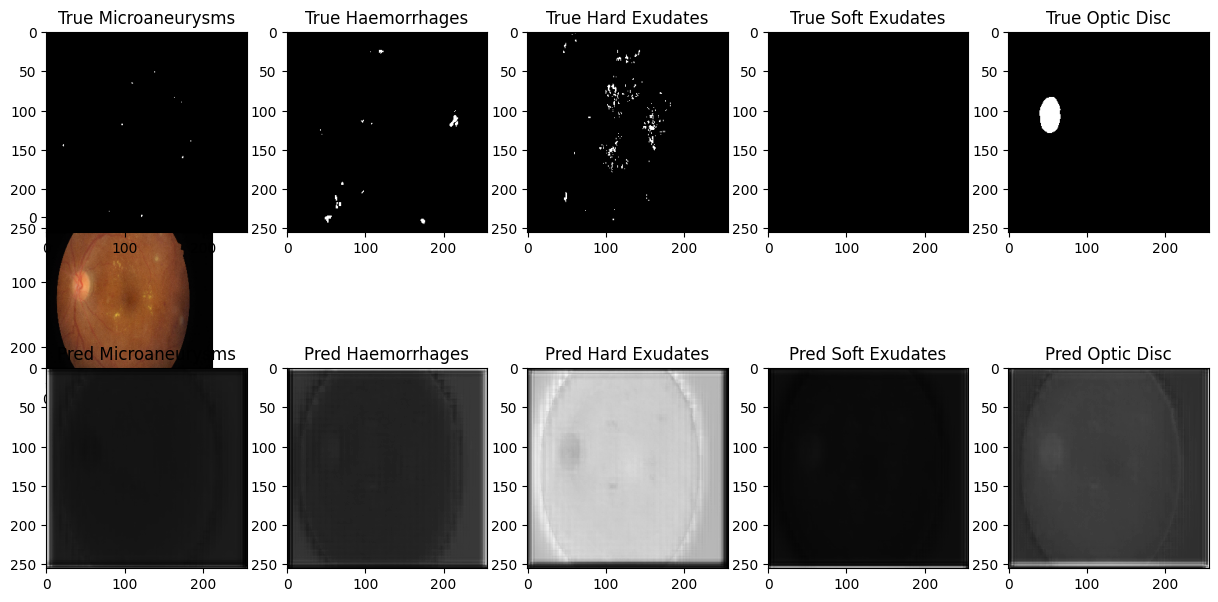

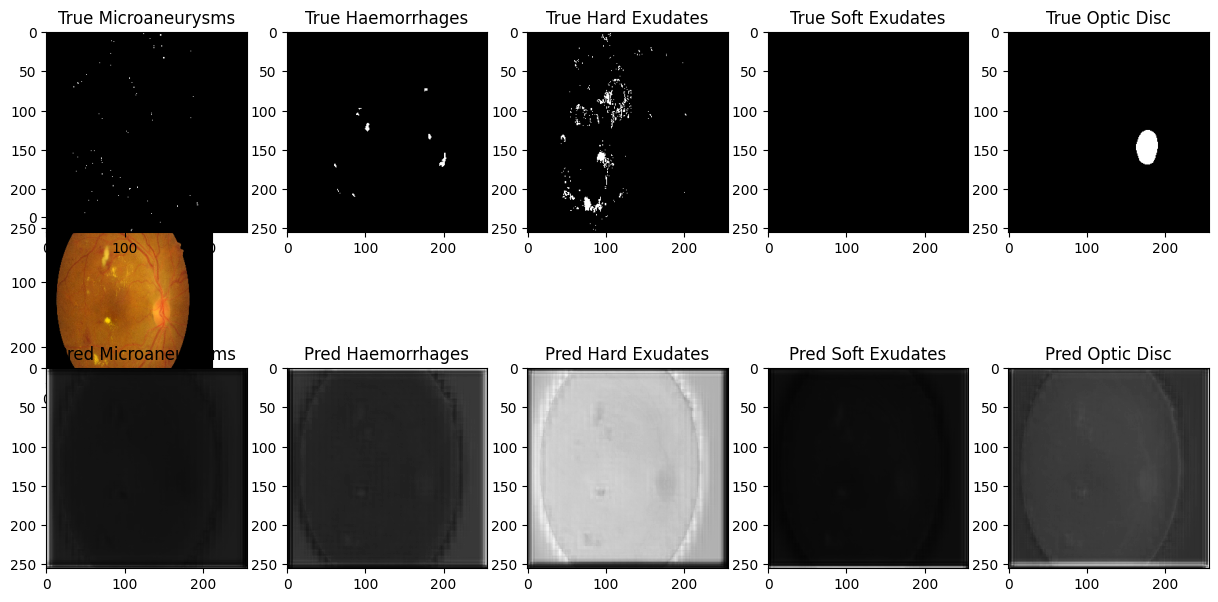

In [ ]:
import matplotlib.pyplot as plt

def visualize_predictions(model, X, y_true, lesion_names, num_samples=3):
    y_pred = model.predict(X)  # Get predicted masks

    for i in range(num_samples):  # Visualize a few samples
        plt.figure(figsize=(15, 8))

        # Original Image
        plt.subplot(1, len(lesion_names) + 1, 1)  # Subplot for original image
        plt.title("Original Image")
        plt.imshow(X[i])  # Display the original RGB image

        # Ground Truth and Predicted Masks
        for j, lesion in enumerate(lesion_names):
            # Subplot for ground truth mask
            plt.subplot(2, len(lesion_names), j + 1)  # Subplot for ground truth masks
            plt.title(f"True {lesion}")
            plt.imshow(y_true[i, :, :, j], cmap='gray')

            # Subplot for predicted mask
            plt.subplot(2, len(lesion_names), j + len(lesion_names) + 1) # Subplot for predicted masks
            plt.title(f"Pred {lesion}")
            plt.imshow(y_pred[i, :, :, j], cmap='gray')

        plt.tight_layout()
        plt.show()

# Example usage
lesion_names = ["Microaneurysms", "Haemorrhages", "Hard Exudates", "Soft Exudates", "Optic Disc"]
visualize_predictions(model, X_test, y_test, lesion_names)

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator

class ResidualBlock(layers.Layer):
    def __init__(self, filters, **kwargs):
        super(ResidualBlock, self).__init__(**kwargs)
        self.conv1 = layers.Conv2D(filters, (3, 3), padding='same', activation='relu')
        self.conv2 = layers.Conv2D(filters, (3, 3), padding='same', activation='relu')
        self.channel_adjust = layers.Conv2D(filters, (1, 1), padding='same')
        self.add = layers.Add()

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.conv2(x)
        inputs = self.channel_adjust(inputs)
        return self.add([x, inputs])

class SwinTransformerBlock(layers.Layer):
    def __init__(self, embed_dim=64, num_heads=4, window_size=7, shift_size=0, **kwargs):
        super(SwinTransformerBlock, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.window_size = window_size
        self.shift_size = shift_size

    def build(self, input_shape):
        self.norm1 = layers.LayerNormalization()
        self.attn = layers.MultiHeadAttention(num_heads=self.num_heads, key_dim=self.embed_dim // self.num_heads)
        self.norm2 = layers.LayerNormalization()
        self.mlp = tf.keras.Sequential([
            layers.Dense(self.embed_dim * 4, activation='gelu'),
            layers.Dense(self.embed_dim)
        ])

    def call(self, inputs):
        x = self.norm1(inputs)
        x = self.attn(x, x)
        x = x + inputs
        x = self.norm2(x)
        x = self.mlp(x)
        return x + inputs

def swin_unet(input_shape=(256, 256, 3)):
    inputs = layers.Input(input_shape)

    # Encoder: Downsampling path
    x1 = ResidualBlock(64)(inputs)
    x2 = layers.MaxPooling2D((2, 2))(x1)
    x2 = ResidualBlock(128)(x2)
    x3 = layers.MaxPooling2D((2, 2))(x2)
    x3 = ResidualBlock(256)(x3)
    x4 = layers.MaxPooling2D((2, 2))(x3)
    x4 = ResidualBlock(512)(x4)

    # Bottleneck: Swin Transformer Blocks
    x5 = SwinTransformerBlock(embed_dim=512)(x4)
    x5 = SwinTransformerBlock(embed_dim=512)(x5)

    # Decoder: Upsampling path
    x6 = layers.UpSampling2D((2, 2))(x5)
    x6 = ResidualBlock(256)(x6)
    x6 = layers.Concatenate()([x6, x3])

    x7 = layers.UpSampling2D((2, 2))(x6)
    x7 = ResidualBlock(128)(x7)
    x7 = layers.Concatenate()([x7, x2])

    x8 = layers.UpSampling2D((2, 2))(x7)
    x8 = ResidualBlock(64)(x8)
    x8 = layers.Concatenate()([x8, x1])

    # Output layer with softmax activation for multi-class segmentation (5 classes)
    outputs = layers.Conv2D(5, (1, 1), activation='softmax')(x8)

    return Model(inputs, outputs)

# Instantiate the model
model = swin_unet(input_shape=(256, 256, 3))
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss=CategoricalCrossentropy(),
              metrics=['accuracy', tf.keras.metrics.MeanIoU(num_classes=5)])
model.summary()

# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Assuming X_train, y_train, X_test, y_test are already defined
# Fit the model
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint("best_swin_unet_model_with_residuals_multi_lesions.keras", save_best_only=True)
]

model.fit(datagen.flow(X_train, y_train, batch_size=4),
          validation_data=(X_test, y_test),
          epochs=100,
          callbacks=callbacks)

# Save the model
model.save("swin_unet_model_multi_lesions_final.h5")

# Evaluate the model
loss, accuracy, mean_iou = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")
print(f"Test Mean IoU: {mean_iou}")


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ residual_block_7          │ (None, 256, 256, 64)   │         38,976 │ input_layer_2[0][0]    │
│ (ResidualBlock)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 128, 128, 64)   │              0 │ residual_block_7[0][0] │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ residual_block_8          │ (None, 128, 128, 128)  │        229,760 │ max_pooling2d_3[0][0]  │
│ (ResidualBlock)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 64, 64, 128)    │              0 │ residual_block_8[0][0] │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ residual_block_9          │ (None, 64, 64, 256)    │        918,272 │ max_pooling2d_4[0][0]  │
│ (ResidualBlock)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_5           │ (None, 32, 32, 256)    │              0 │ residual_block_9[0][0] │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ residual_block_10         │ (None, 32, 32, 512)    │      3,671,552 │ max_pooling2d_5[0][0]  │
│ (ResidualBlock)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ swin_transformer_block_1  │ (None, 32, 32, 512)    │      3,152,384 │ residual_block_10[0][… │
│ (SwinTransformerBlock)    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ swin_transformer_block_2  │ (None, 32, 32, 512)    │      3,152,384 │ swin_transformer_bloc… │
│ (SwinTransformerBlock)    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d_3           │ (None, 64, 64, 512)    │              0 │ swin_transformer_bloc… │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ residual_block_11         │ (None, 64, 64, 256)    │      1,901,312 │ up_sampling2d_3[0][0]  │
│ (ResidualBlock)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_3             │ (None, 64, 64, 512)    │              0 │ residual_block_11[0][… │
│ (Concatenate)             │                        │                │ residual_block_9[0][0] │
├──────────────────────

 Total params: 14,069,381 (53.67 MB)

 Trainable params: 14,069,381 (53.67 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


10/10 ━━━━━━━━━━━━━━━━━━━━ 415s 40s/step - accuracy: 0.1629 - loss: 0.0274 - mean_io_u_1: 1.0000 - val_accuracy: 0.0557 - val_loss: 0.0192 - val_mean_io_u_1: 1.0000
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 476s 44s/step - accuracy: 0.2462 - loss: 0.0428 - mean_io_u_1: 1.0000 - val_accuracy: 0.0176 - val_loss: 0.0457 - val_mean_io_u_1: 1.0000
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 435s 43s/step - accuracy: 0.0284 - loss: 0.5182 - mean_io_u_1: 1.0000 - val_accuracy: 0.0366 - val_loss: 2.2388 - val_mean_io_u_1: 1.0000
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 443s 46s/step - accuracy: 0.1831 - loss: 5.5543 - mean_io_u_1: 1.0000 - val_accuracy: 0.0292 - val_loss: 11.5277 - val_mean_io_u_1: 1.0000
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 436s 44s/step - accuracy: 0.2540 - loss: 38.7337 - mean_io_u_1: 1.0000 - val_accuracy: 0.0175 - val_loss: 241.1993 - val_mean_io_u_1: 1.0000
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 432s 44s/step - accuracy: 0.0443 - loss: 1465.0229 - mean_io_u_1: 1.0000 - val_accur

1/1 ━━━━━━━━━━━━━━━━━━━━ 46s 46s/step - accuracy: 0.0557 - loss: 0.0192 - mean_io_u_1: 1.0000
Test Loss: 0.019161533564329147
Test Accuracy: 0.055745743215084076
Test Mean IoU: 0.9999998807907104


In [ ]:
# post preprocessing
import cv2
import numpy as np

def post_process(pred_mask):
    pred_mask = (pred_mask > 0.5).astype(np.uint8)
    kernel = np.ones((3, 3), np.uint8)
    pred_mask = cv2.morphologyEx(pred_mask, cv2.MORPH_CLOSE, kernel)
    pred_mask = cv2.morphologyEx(pred_mask, cv2.MORPH_OPEN, kernel)
    return pred_mask

# Apply post-processing to the predicted masks
pred_masks = model.predict(X_test)
post_processed_masks = [post_process(mask) for mask in pred_masks]


1/1 ━━━━━━━━━━━━━━━━━━━━ 47s 47s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 46s 46s/step


<ipython-input-11-f36fe8c18dcf>:26: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()


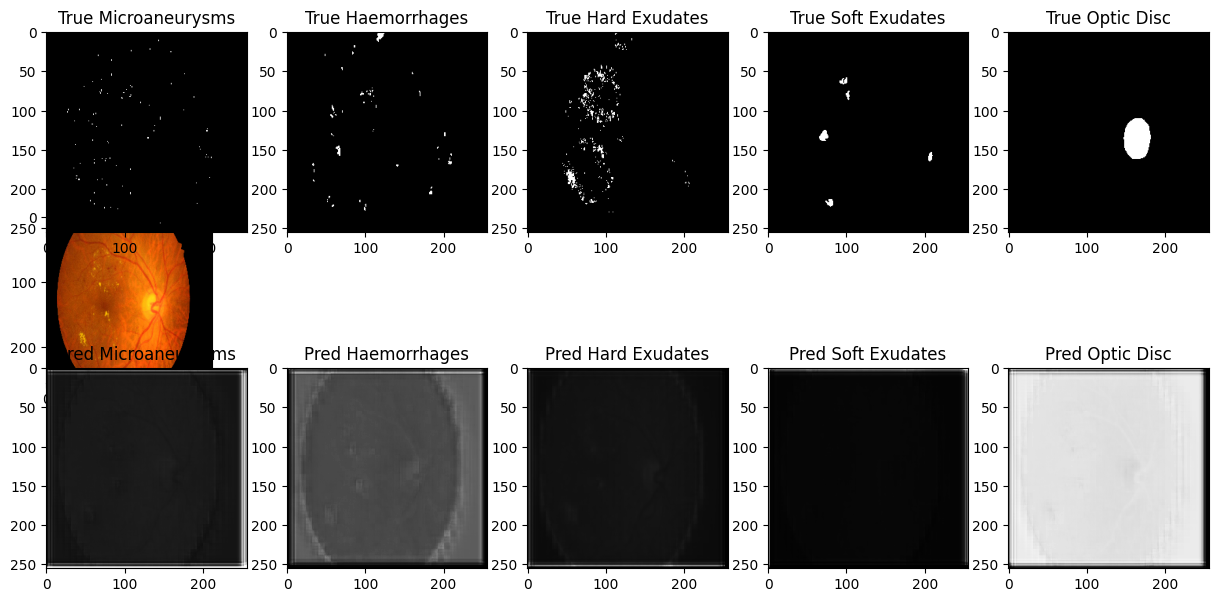

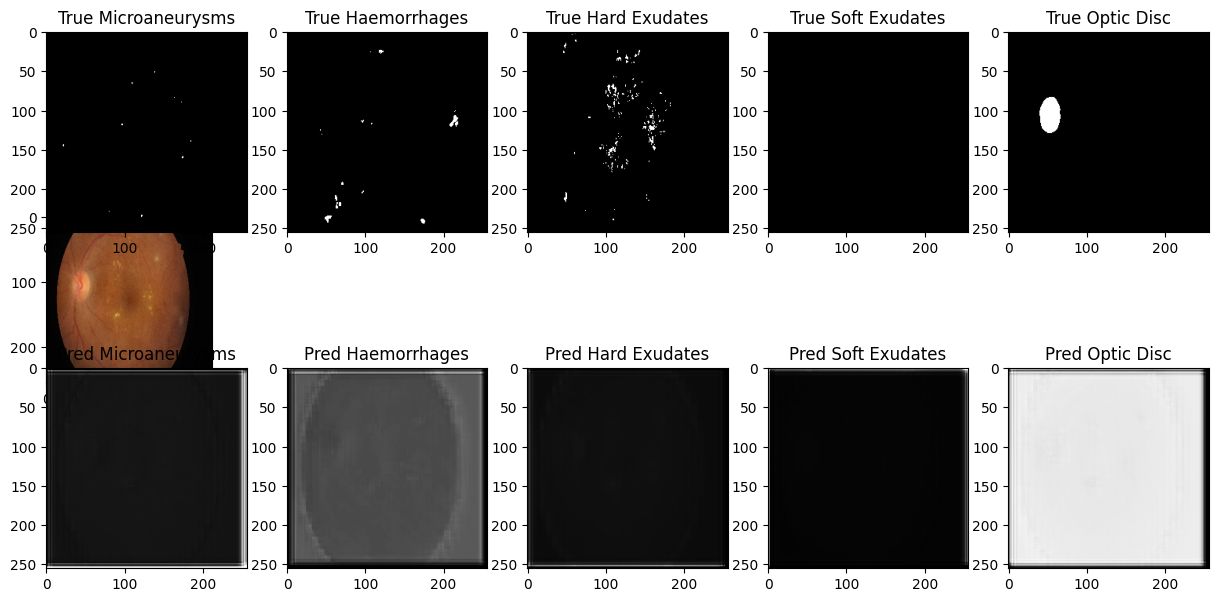

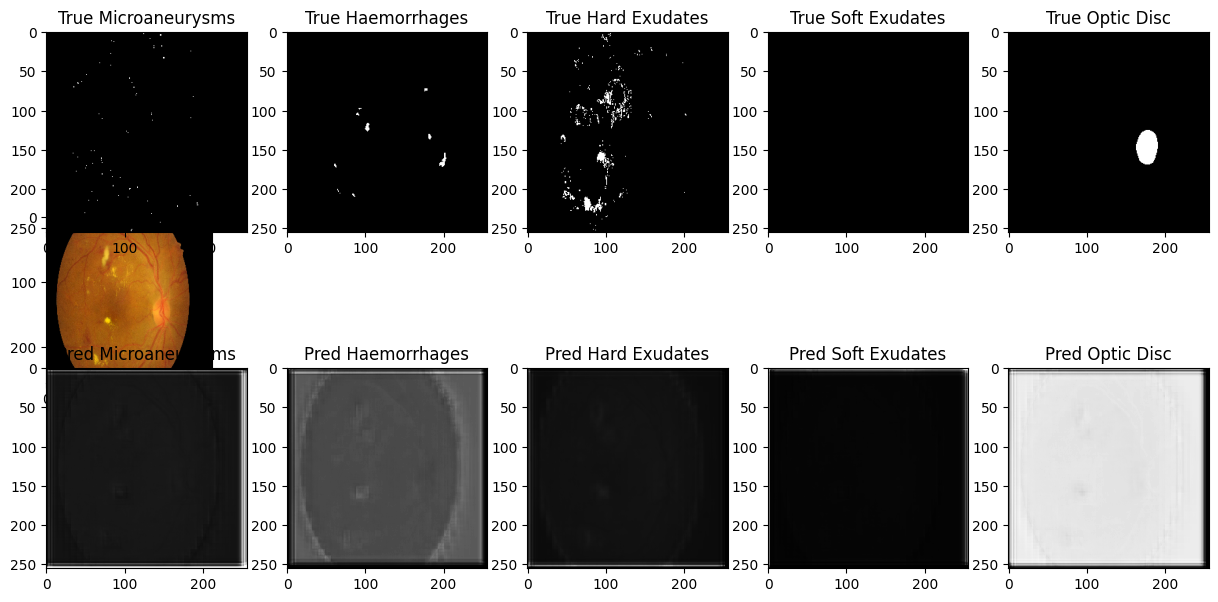

In [ ]:
import matplotlib.pyplot as plt

def visualize_predictions(model, X, y_true, lesion_names, num_samples=3):
    y_pred = model.predict(X)  # Get predicted masks

    for i in range(num_samples):  # Visualize a few samples
        plt.figure(figsize=(15, 8))

        # Original Image
        plt.subplot(1, len(lesion_names) + 1, 1)  # Subplot for original image
        plt.title("Original Image")
        plt.imshow(X[i])  # Display the original RGB image

        # Ground Truth and Predicted Masks
        for j, lesion in enumerate(lesion_names):
            # Subplot for ground truth mask
            plt.subplot(2, len(lesion_names), j + 1)  # Subplot for ground truth masks
            plt.title(f"True {lesion}")
            plt.imshow(y_true[i, :, :, j], cmap='gray')

            # Subplot for predicted mask
            plt.subplot(2, len(lesion_names), j + len(lesion_names) + 1) # Subplot for predicted masks
            plt.title(f"Pred {lesion}")
            plt.imshow(y_pred[i, :, :, j], cmap='gray')

        plt.tight_layout()
        plt.show()

# Example usage
lesion_names = ["Microaneurysms", "Haemorrhages", "Hard Exudates", "Soft Exudates", "Optic Disc"]
visualize_predictions(model, X_test, y_test, lesion_names)

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11            │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ residual_block_28         │ (None, 256, 256, 64)   │         38,976 │ input_layer_11[0][0]   │
│ (ResidualBlock)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_12          │ (None, 128, 128, 64)   │              0 │ residual_block_28[0][… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ residual_block_29         │ (None, 128, 128, 128)  │        229,760 │ max_pooling2d_12[0][0] │
│ (ResidualBlock)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_13          │ (None, 64, 64, 128)    │              0 │ residual_block_29[0][… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ residual_block_30         │ (None, 64, 64, 256)    │        918,272 │ max_pooling2d_13[0][0] │
│ (ResidualBlock)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_14          │ (None, 32, 32, 256)    │              0 │ residual_block_30[0][… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ residual_block_31         │ (None, 32, 32, 512)    │      3,671,552 │ max_pooling2d_14[0][0] │
│ (ResidualBlock)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ swin_transformer_block_7  │ (None, 32, 32, 512)    │      3,152,384 │ residual_block_31[0][… │
│ (SwinTransformerBlock)    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ swin_transformer_block_8  │ (None, 32, 32, 512)    │      3,152,384 │ swin_transformer_bloc… │
│ (SwinTransformerBlock)    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d_12          │ (None, 64, 64, 512)    │              0 │ swin_transformer_bloc… │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ residual_block_32         │ (None, 64, 64, 256)    │      1,901,312 │ up_sampling2d_12[0][0] │
│ (ResidualBlock)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_12            │ (None, 64, 64, 512)    │              0 │ residual_block_32[0][… │
│ (Concatenate)             │                        │                │ residual_block_30[0][… │
├──────────────────────

 Total params: 14,069,381 (53.67 MB)

 Trainable params: 14,069,381 (53.67 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 447s 47s/step - accuracy: 0.0832 - loss: 1.2160 - mean_io_u_4: 1.0000 - val_accuracy: 0.0073 - val_loss: 1.0382 - val_mean_io_u_4: 1.0000
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 425s 46s/step - accuracy: 0.1410 - loss: 1.0292 - mean_io_u_4: 1.0000 - val_accuracy: 0.7128 - val_loss: 1.0178 - val_mean_io_u_4: 1.0000
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 414s 39s/step - accuracy: 0.3065 - loss: 1.0117 - mean_io_u_4: 1.0000 - val_accuracy: 0.5531 - val_loss: 1.0076 - val_mean_io_u_4: 1.0000
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 448s 40s/step - accuracy: 0.2208 - loss: 1.0054 - mean_io_u_4: 1.0000 - val_accuracy: 0.4892 - val_loss: 1.0029 - val_mean_io_u_4: 1.0000
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 386s 39s/step - accuracy: 0.0999 - loss: 1.0031 - mean_io_u_4: 1.0000 - val_accuracy: 0.0677 - val_loss: 1.0030 - val_mean_io_u_4: 1.0000
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 482s 43s/step - accuracy: 0.0631 - loss: 1.0025 - mean_io_u_4: 1.0000 - val_accura

1/1 ━━━━━━━━━━━━━━━━━━━━ 47s 47s/step - accuracy: 0.0471 - loss: 1.0024 - mean_io_u_4: 1.0000
Test Loss: 1.0023977756500244
Test Accuracy: 0.047142475843429565
Test Mean IoU: 0.9999998807907104
1/1 ━━━━━━━━━━━━━━━━━━━━ 45s 45s/step


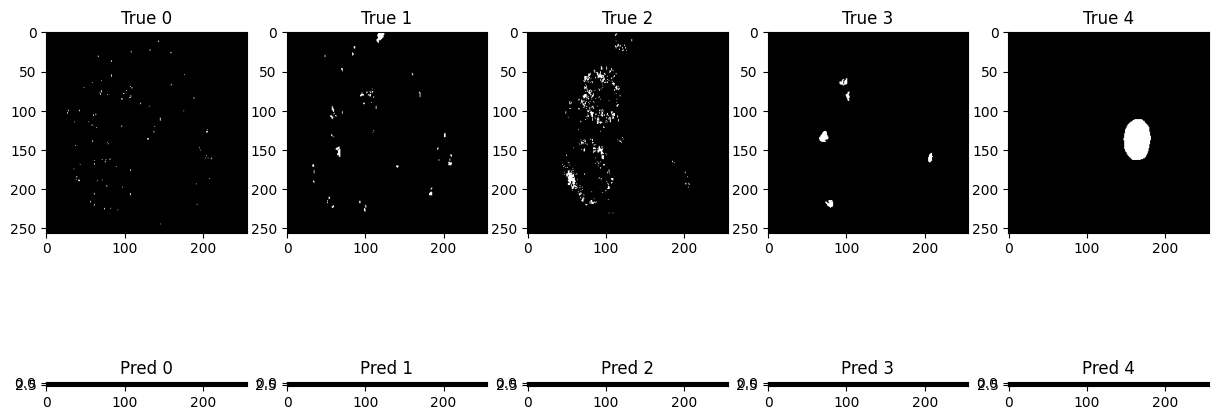

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Loss
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Custom Loss Functions
class DiceLoss(Loss):
    def __init__(self, smooth=1e-6, **kwargs):
        super(DiceLoss, self).__init__(**kwargs)
        self.smooth = smooth

    def call(self, y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)
        intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
        union = tf.reduce_sum(y_true, axis=[1, 2, 3]) + tf.reduce_sum(y_pred, axis=[1, 2, 3])
        dice = tf.reduce_mean((2. * intersection + self.smooth) / (union + self.smooth), axis=0)
        return 1 - dice

class FocalLoss(Loss):
    def __init__(self, gamma=2.0, alpha=0.25, **kwargs):
        super(FocalLoss, self).__init__(**kwargs)
        self.gamma = gamma
        self.alpha = alpha

    def call(self, y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)
        alpha_t = y_true * self.alpha + (tf.ones_like(y_true) - y_true) * (1 - self.alpha)
        p_t = y_true * y_pred + (tf.ones_like(y_true) - y_true) * (tf.ones_like(y_true) - y_pred)
        focal_loss = -alpha_t * tf.pow((tf.ones_like(y_true) - p_t), self.gamma) * tf.math.log(p_t + tf.keras.backend.epsilon())
        return tf.reduce_mean(focal_loss)

# Combined Loss
def combined_loss(y_true, y_pred):
    return DiceLoss()(y_true, y_pred) + FocalLoss()(y_true, y_pred)

# Residual Block
class ResidualBlock(layers.Layer):
    def __init__(self, filters, **kwargs):
        super(ResidualBlock, self).__init__(**kwargs)
        self.conv1 = layers.Conv2D(filters, (3, 3), padding='same', activation='relu')
        self.conv2 = layers.Conv2D(filters, (3, 3), padding='same', activation='relu')
        self.channel_adjust = layers.Conv2D(filters, (1, 1), padding='same')
        self.add = layers.Add()

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.conv2(x)
        inputs = self.channel_adjust(inputs)
        return self.add([x, inputs])

# Swin Transformer Block
class SwinTransformerBlock(layers.Layer):
    def __init__(self, embed_dim=64, num_heads=4, window_size=7, shift_size=0, **kwargs):
        super(SwinTransformerBlock, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.window_size = window_size
        self.shift_size = shift_size

    def build(self, input_shape):
        self.norm1 = layers.LayerNormalization()
        self.attn = layers.MultiHeadAttention(num_heads=self.num_heads, key_dim=self.embed_dim // self.num_heads)
        self.norm2 = layers.LayerNormalization()
        self.mlp = tf.keras.Sequential([
            layers.Dense(self.embed_dim * 4, activation='gelu'),
            layers.Dense(self.embed_dim)
        ])

    def call(self, inputs):
        x = self.norm1(inputs)
        x = self.attn(x, x)
        x = x + inputs
        x = self.norm2(x)
        x = self.mlp(x)
        return x + inputs

# Swin U-Net Model
def swin_unet(input_shape=(256, 256, 3)):
    inputs = layers.Input(input_shape)

    # Encoder: Downsampling path
    x1 = ResidualBlock(64)(inputs)
    x2 = layers.MaxPooling2D((2, 2))(x1)
    x2 = ResidualBlock(128)(x2)
    x3 = layers.MaxPooling2D((2, 2))(x2)
    x3 = ResidualBlock(256)(x3)
    x4 = layers.MaxPooling2D((2, 2))(x3)
    x4 = ResidualBlock(512)(x4)

    # Bottleneck: Swin Transformer Blocks
    x5 = SwinTransformerBlock(embed_dim=512)(x4)
    x5 = SwinTransformerBlock(embed_dim=512)(x5)

    # Decoder: Upsampling path
    x6 = layers.UpSampling2D((2, 2))(x5)
    x6 = ResidualBlock(256)(x6)
    x6 = layers.Concatenate()([x6, x3])

    x7 = layers.UpSampling2D((2, 2))(x6)
    x7 = ResidualBlock(128)(x7)
    x7 = layers.Concatenate()([x7, x2])

    x8 = layers.UpSampling2D((2, 2))(x7)
    x8 = ResidualBlock(64)(x8)
    x8 = layers.Concatenate()([x8, x1])

    # Output layer with softmax activation for multi-class segmentation (5 classes)
    outputs = layers.Conv2D(5, (1, 1), activation='softmax')(x8)

    return Model(inputs, outputs)

# Instantiate the model
model = swin_unet(input_shape=(256, 256, 3))
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss=combined_loss,
              metrics=['accuracy', tf.keras.metrics.MeanIoU(num_classes=5)])
model.summary()

# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

# Assuming X_train, y_train, X_test, y_test are already defined
# Fit the model
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ModelCheckpoint("best_swin_unet_model_with_residuals_multi_lesions.keras", save_best_only=True)
]

model.fit(datagen.flow(X_train, y_train, batch_size=4),
          validation_data=(X_test, y_test),
          epochs=10,
          callbacks=callbacks)

# Save the model
model.save("swin_unet_model_multi_lesions_final.h5")

# Evaluate the model
loss, accuracy, mean_iou = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")
print(f"Test Mean IoU: {mean_iou}")

# Post-Processing
def post_process(pred_mask):
    pred_mask = (pred_mask > 0.5).astype(np.uint8)
    kernel = np.ones((3, 3), np.uint8)
    pred_mask = cv2.morphologyEx(pred_mask, cv2.MORPH_CLOSE, kernel)
    pred_mask = cv2.morphologyEx(pred_mask, cv2.MORPH_OPEN, kernel)
    return pred_mask

# Apply post-processing to the predicted masks
pred_masks = model.predict(X_test)
post_processed_masks = np.array([[post_process(mask[:, :, i]) for i in range(5)] for mask in pred_masks])

# Visualization
def visualize_results(images, true_masks, pred_masks, num_classes=5):
    fig, axes = plt.subplots(2, num_classes, figsize=(15, 6))
    for i in range(num_classes):
        axes[0, i].imshow(true_masks[0, :, :, i], cmap='gray')
        axes[0, i].set_title(f'True {i}')
        axes[1, i].imshow(pred_masks[0, :, :, i], cmap='gray')
        axes[1, i].set_title(f'Pred {i}')
    plt.show()

# Visualize the results
visualize_results(X_test, y_test, post_processed_masks)
